In [1]:
import time
import illustris_python as il
import matplotlib.pyplot as plt
import numpy as np
import h5py
import numba as nb
from numba import jit, njit
import tracerFuncs as tF
import locatingFuncs as lF
import illustrisFuncs as iF
import funcs
import matplotlib as mpl
from matplotlib.patches import Rectangle
from os.path import isfile
import os
import dm

import sys

import matplotlib.lines as mlines
import matplotlib.patches as mpatches
import matplotlib as mpl

plt.style.use('fancy_plots2.mplstyle')

## check how many 'false' in-situ stars there are

In [2]:
run = 1
basePath=f'/virgotng/universe/IllustrisTNG/TNG50-{run}/output'
stype = 'insitu'
file = '/vera/ptmp/gc/olwitt/' + stype + f'/TNG50-{run}/infall_and_leaving_times.hdf5'
f = h5py.File(file,'r')
halo_infall_snaps = f['halo_infall'][:]
galaxy_infall_snaps = f['galaxy_infall'][:]
IGM_leaving = f['leaving_igm'][:]
f.close()

f = h5py.File('/vera/ptmp/gc/olwitt/' + stype + f'/TNG50-{run}/star_formation_snapshots.hdf5','r')
star_formation_snaps = f['star_formation_snapshot'][:]
f.close()

In [3]:
print(halo_infall_snaps.shape)
print(galaxy_infall_snaps.shape)
print(star_formation_snaps.shape)

(591404257,)
(591404257,)
(591404257,)


In [4]:
# neg_one are all tracers that never entered the galaxy itself but remained in the halo
neg_one = np.where(galaxy_infall_snaps == -1)[0]
print(neg_one.shape, ' = ',np.round(neg_one.shape[0] / halo_infall_snaps.shape[0] * 100,1),'%')

true_insitu = np.where(np.logical_and(star_formation_snaps >= galaxy_infall_snaps, galaxy_infall_snaps != -1))[0]
print(true_insitu.shape, ' = ',np.round(true_insitu.shape[0] / halo_infall_snaps.shape[0] * 100,1),'%')
false_insitu = np.where(np.logical_and(star_formation_snaps < galaxy_infall_snaps, star_formation_snaps!= -1))[0]
print(false_insitu.shape, ' = ',np.round(false_insitu.shape[0] / halo_infall_snaps.shape[0] * 100,1),'%')

(215787131,)  =  36.5 %
(275019059,)  =  46.5 %
(100598025,)  =  17.0 %


In [5]:
print(np.where(galaxy_infall_snaps < halo_infall_snaps)[0].shape)

(21442148,)


## plot distribution of those percentages vs stellar mass

In [2]:
run = 1
basePath=f'/virgotng/universe/IllustrisTNG/TNG50-{run}/output'
stype = 'insitu'
file = '/vera/ptmp/gc/olwitt/' + stype + f'/TNG50-{run}/infall_and_leaving_times.hdf5'
f = h5py.File(file,'r')
halo_infall_snaps = f['halo_infall'][:]
galaxy_infall_snaps = f['galaxy_infall'][:]
IGM_leaving = f['leaving_igm'][:]
f.close()

f = h5py.File('/vera/ptmp/gc/olwitt/' + stype + f'/TNG50-{run}/star_formation_snapshots.hdf5','r')
star_formation_snaps = f['star_formation_snapshot'][:]
f.close()

f = h5py.File('/vera/ptmp/gc/olwitt/' + stype + f'/TNG50-{run}/parent_indices_99.hdf5','r')
numTracersInParents = f['snap_99/numTracersInParents'][:]
f.close()
insituStarsInSubOffset = tF.insituStarsInSubOffset(basePath,99)
final_offsets = tF.tracersInSubhalo(insituStarsInSubOffset,numTracersInParents).astype(int)
final_offsets = np.insert(final_offsets,0,0)

In [3]:
file = '/vera/ptmp/gc/olwitt/' + stype + f'/TNG50-{run}/lagrangian_regions/lagrangian_regions_99.hdf5'
f = h5py.File(file,'r')
subhaloFlag_99 = f['subhaloFlag'][:]
# dwarf_inds = f['mass_bin_indices/sub_ids_dwarf'][:]
# mw_inds = f['mass_bin_indices/sub_ids_mw'][:]
# group_inds = f['mass_bin_indices/sub_ids_group'][:]
# giant_inds = f['mass_bin_indices/sub_ids_giant'][:]

location_status = f['tracers_inside_galaxy'][:]

f.close()

# gfs = il.groupcat.loadHalos(basePath, 99, fields = ['GroupFirstSub'])
subs = np.nonzero(subhaloFlag_99) #which subs were used for analysis (at snapshot 99)

In [4]:
#compute fractions for ALL galaxies. however, only a small amount of centrals was really used -> retrieve that information
@njit
def sub_fracs(offsets, halo_infall_snaps, galaxy_infall_snaps, star_formation_snaps, location_at_snap99):
    num_subs = offsets.shape[0] - 1
    form_out_loc_out = np.full(num_subs, 0, dtype = np.float32)
    form_out_loc_in = np.full(num_subs, 0, dtype = np.float32)
    form_in_loc_out = np.full(num_subs, 0, dtype = np.float32)
    form_in_loc_in = np.full(num_subs, 0, dtype = np.float32)
    always_out = np.full(num_subs, 0, dtype = np.float32)
    
    check = np.ones(location_at_snap99.shape[0], dtype = np.ubyte)
    
    for i in range(num_subs):
        indices_of_sub = np.arange(offsets[i],offsets[i+1])
        if indices_of_sub.shape[0] > 0:
            neg_one = np.where(galaxy_infall_snaps[indices_of_sub] == -1)[0]
            always_out[i] = neg_one.shape[0]/indices_of_sub.shape[0]
            check[indices_of_sub[neg_one]] = 0
            #---
            in_in = np.where(np.logical_and(np.logical_and(star_formation_snaps[indices_of_sub] >=\
                                                  galaxy_infall_snaps[indices_of_sub], galaxy_infall_snaps[indices_of_sub]\
                                                  != -1), location_at_snap99[indices_of_sub] == 1))[0]
            check[indices_of_sub[in_in]] = 0
            form_in_loc_in[i] = in_in.shape[0] / indices_of_sub.shape[0]
            #---
            in_out = np.where(np.logical_and(np.logical_and(star_formation_snaps[indices_of_sub] >=\
                                                  galaxy_infall_snaps[indices_of_sub], galaxy_infall_snaps[indices_of_sub]\
                                                  != -1), location_at_snap99[indices_of_sub] == 0))[0]
            form_in_loc_out[i] = in_out.shape[0] / indices_of_sub.shape[0]
            check[indices_of_sub[in_out]] = 0
            #---
            out_in = np.where(np.logical_and(np.logical_and(star_formation_snaps[indices_of_sub] <\
                                                  galaxy_infall_snaps[indices_of_sub], galaxy_infall_snaps[indices_of_sub]\
                                                  != -1), location_at_snap99[indices_of_sub] == 1))[0]
            form_out_loc_in[i] = out_in.shape[0] / indices_of_sub.shape[0]
            check[indices_of_sub[out_in]] = 0
            #---
            out_out = np.where(np.logical_or(np.logical_and(np.logical_and(star_formation_snaps[indices_of_sub] <\
                                                  galaxy_infall_snaps[indices_of_sub], galaxy_infall_snaps[indices_of_sub]\
                                                  != -1), location_at_snap99[indices_of_sub] == 0),\
                                             galaxy_infall_snaps[indices_of_sub] == -1))[0]
            form_out_loc_out[i] = out_out.shape[0] / indices_of_sub.shape[0]
            check[indices_of_sub[out_out]] = 0
            
            if i == 0:
                print(np.nonzero(funcs.isin(neg_one, out_out))[0].shape[0])
            
    print(np.nonzero(check)[0].shape[0])
    return always_out, form_in_loc_in, form_in_loc_out, form_out_loc_in, form_out_loc_out

In [11]:
always_out, form_in_loc_in, form_in_loc_out, form_out_loc_in, form_out_loc_out = sub_fracs(final_offsets, halo_infall_snaps, galaxy_infall_snaps,\
                                                              star_formation_snaps, location_status)

10520162
17622196


In [12]:
h_const = il.groupcat.loadHeader(basePath, 99)['HubbleParam']
stellar_masses = il.groupcat.loadSubhalos(basePath, 99, fields = ['SubhaloMassType'])[:,4] * 1e10 / h_const
stellar_masses = funcs.log10_mod(stellar_masses[subs])
always_out = always_out[subs]
form_in_loc_in = form_in_loc_in[subs]
form_in_loc_out = form_in_loc_out[subs]
form_out_loc_in = form_out_loc_in[subs]
form_out_loc_out = form_out_loc_out[subs]
med_situ_fracs = form_out_loc_in + form_out_loc_out
in_situ_fracs = form_in_loc_in + form_in_loc_out

In [13]:
num_bins = 15
mass_bins, always_out_bins = funcs.binData_mean(stellar_masses, always_out, num_bins)
_, form_in_loc_in_bins = funcs.binData_mean(stellar_masses, form_in_loc_in, num_bins)
_, form_in_loc_out_bins = funcs.binData_mean(stellar_masses, form_in_loc_out, num_bins)
_, form_out_loc_in_bins = funcs.binData_mean(stellar_masses, form_out_loc_in, num_bins)
_, form_out_loc_out_bins = funcs.binData_mean(stellar_masses, form_out_loc_out, num_bins)
_, med_situ_bins = funcs.binData_mean(stellar_masses, med_situ_fracs, num_bins)
_, in_situ_bins = funcs.binData_mean(stellar_masses, in_situ_fracs, num_bins)

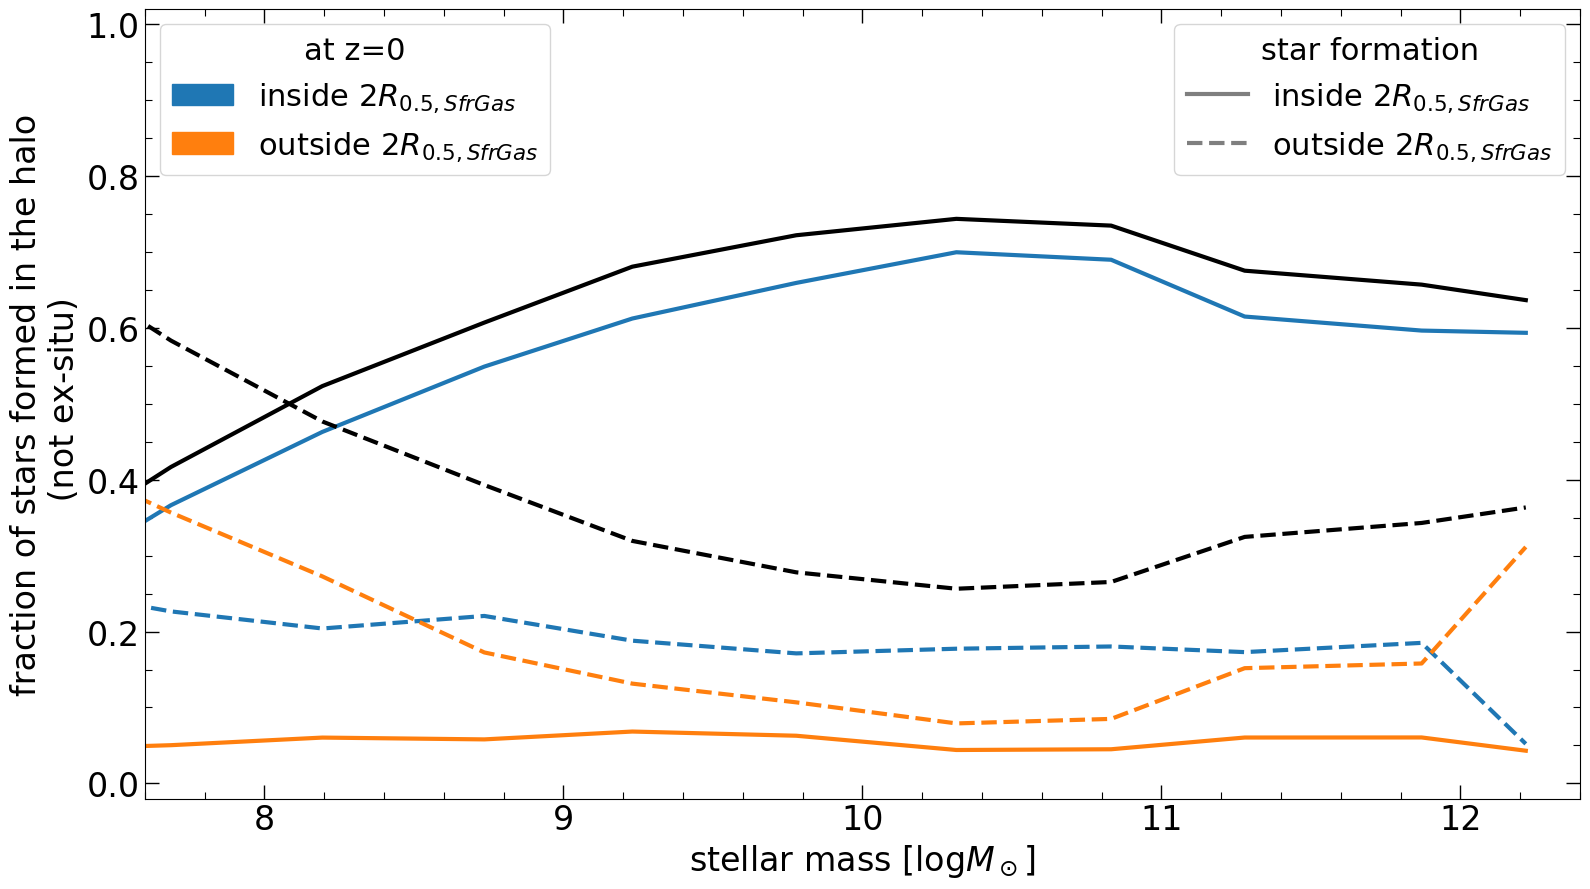

In [16]:
# plt.hist2d(stellar_masses, false_insitu_subs, cmap = 'Blues', norm = mpl.colors.LogNorm(), bins = (128,64))
# plt.colorbar()


plt.plot(mass_bins, form_in_loc_in_bins, color = 'tab:blue', linestyle = 'solid')
plt.plot(mass_bins, form_out_loc_in_bins, color = 'tab:blue', linestyle = 'dashed')
plt.plot(mass_bins, form_in_loc_out_bins, color = 'tab:orange', linestyle = 'solid')
plt.plot(mass_bins, form_out_loc_out_bins, color = 'tab:orange', linestyle = 'dashed')
plt.plot(mass_bins, med_situ_bins, color = 'black', linestyle = 'dashed')
plt.plot(mass_bins, in_situ_bins, color = 'black', linestyle = 'solid')
# plt.plot(mass_bins, np.nansum(np.array([form_in_loc_in_bins, form_in_loc_out_bins, form_out_loc_in_bins,\
#                                         form_out_loc_out_bins,]), axis = 0), color = 'black')

plt.xlabel(r'stellar mass [$\log{M_\odot}$]')
plt.ylabel('fraction of stars formed in the halo\n (not ex-situ)')

z0_loc = mlines.Line2D([], [], color='white', label='at z=0')
blank = mlines.Line2D([], [], color='white')

loc_in = mpatches.Patch(color='tab:blue', label=r'inside 2$R_{0.5,SfrGas}$')
loc_out = mpatches.Patch(color='tab:orange', label=r'outside 2$R_{0.5,SfrGas}$')
all_stars = mpatches.Patch(color='black', label='all stars')
star_form = mlines.Line2D([], [], color='white', label='star formation')
form_in = mlines.Line2D([], [], color='tab:gray', linestyle = 'solid', label=r'inside 2$R_{0.5,SfrGas}$')
form_out = mlines.Line2D([], [], color='tab:gray', linestyle = 'dashed', label=r'outside 2$R_{0.5,SfrGas}$')
med_situ_line  = mlines.Line2D([], [], color='black', linestyle = 'dashed', label=r'med-situ')


legend1 = plt.legend(handles = [loc_in, loc_out], title = 'at z=0', loc = 'upper left')
legend2 = plt.legend(handles = [form_in, form_out], title = 'star formation', loc = 'upper right')

plt.gca().add_artist(legend1)
plt.xlim(7.6,12.4)
plt.ylim(-0.02,1.02)
plt.tight_layout()
plt.savefig(f'pics/med-situ/true_false_insitu_50-{run}_2HMR_Sfr_Gas_alt.pdf', format = 'pdf')

(64, 128)


/mpcdf/soft/SLE_15/packages/x86_64/anaconda/3/2020.02/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: Mean of empty slice
  
/mpcdf/soft/SLE_15/packages/x86_64/anaconda/3/2020.02/lib/python3.7/site-packages/matplotlib/colors.py:1110: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


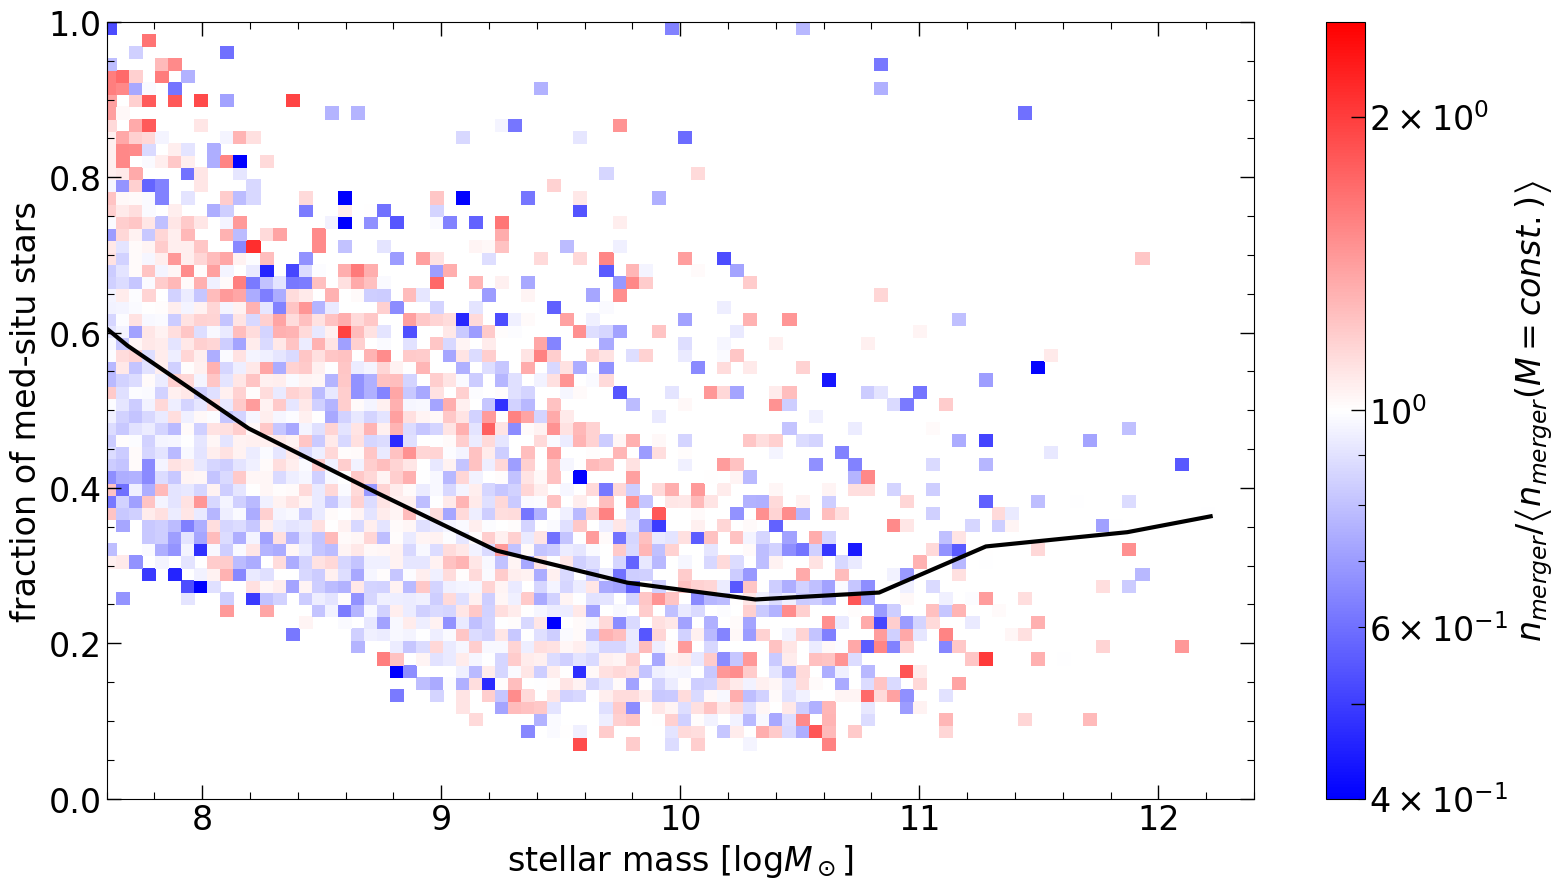

In [14]:
# only green line: scatter false insitu fraction vs mass + color by number of mergers

from scipy.stats import binned_statistic_2d

g = h5py.File(basePath[:-6] + 'postprocessing/MergerHistory/MergerHistory_099.hdf5','r')
numMergers = g['NumMergersTotal'][:]
g.close()

stat, x, y, _ = binned_statistic_2d(stellar_masses, med_situ_fracs, values = numMergers[subs],\
                                    statistic = 'mean', bins = (128,64), range = [[6,13],[0,1]])
print(stat.T.shape)
stat_cols_mod = np.zeros(stat.shape)
for i in range(stat.shape[0]):
    stat_cols_mod[i,:] = stat[i,:] / np.nanmean(stat[i,:])

plt.pcolormesh(x,y,stat_cols_mod.T, cmap = 'bwr', norm = mpl.colors.LogNorm(0.4,2.5), rasterized = True)
cb = plt.colorbar(ticks = [0.5,1,2])
cb.set_label(label=r'$n_{merger}/\left<n_{merger}(M = const.)\right>$')
# plt.hist2d(stellar_masses, false_insitu_subs, cmap = 'plasma', weights = numMergers[subs], norm = mpl.colors.LogNorm(),\
#            bins = (128,64))
# cb = plt.colorbar()
# cb.set_label(label='total number of mergers')

plt.plot(mass_bins, med_situ_bins, color = 'black', label = r'formed outside 2$R_{0.5, \ast}$')

plt.xlabel(r'stellar mass [$\log{M_\odot}$]')
plt.ylabel('fraction of med-situ stars')

plt.xlim(7.6,12.4)
plt.tight_layout()
plt.savefig(f'pics/med-situ/med_situ_num_mergers_50-{run}.pdf', format = 'pdf')

## specific times plot for overleaf

In [2]:
def get_time_difference_in_Gyr(a0, a1):
#   double result, time_diff = 0, t0, t1, factor1, factor2, term1, term2
    omega_lambda = 0.6911
    omega_m = 0.3089
    h = 0.6774
    H0 = 3.2407789e-18
    
    SEC_PER_MEGAYEAR = 1000000 * 365 * 86400
    
    factor1 = 2.0 / (3.0 * np.sqrt(omega_lambda))

    term1   = np.sqrt(omega_lambda / omega_m) * a0**1.5
    term2   = np.sqrt(1 + omega_lambda / omega_m * a0**3)
    factor2 = np.log(term1 + term2)

    t0 = factor1 * factor2

    term1   = np.sqrt(omega_lambda / omega_m) * a1**1.5
    term2   = np.sqrt(1 + omega_lambda / omega_m * a1**3)
    factor2 = np.log(term1 + term2)

    t1 = factor1 * factor2

    result = t1 - t0

    time_diff = result / (H0 * h) #now in seconds
    time_diff /= SEC_PER_MEGAYEAR * 1000            #now in gigayears

    return time_diff


In [3]:
a1 = np.array([0.1,0.5,1])
a2 = np.array([0.0,0.0,0])
print(get_time_difference_in_Gyr(a2,a1))

[ 0.54769248  5.87104677 13.8121739 ]


In [16]:
#compute fractions for ALL galaxies. however, only a small amount of centrals was really used -> retrieve that information
# @njit
def sub_diff(offsets, halo_infall_snaps, galaxy_infall_snaps, star_formation_snaps, a):
    num_subs = offsets.shape[0] - 1
    #works for always outside, in-situ, med-situ
    halo_star_form_diff = np.full((num_subs, 3), np.nan, dtype = np.float32)
    #works for in-situ, med-situ
    halo_gal_diff = np.full((num_subs, 3), np.nan, dtype = np.float32)
    #works for in-situ, med-situ (but negative for med-situ!)
    gal_star_form_diff = np.full((num_subs, 3), np.nan, dtype = np.float32)
    
    check = np.ones(halo_infall_snaps.shape[0], dtype = np.ubyte)
    
    for i in range(num_subs):
        indices_of_sub = np.arange(offsets[i],offsets[i+1])
        if indices_of_sub.shape[0] > 0:
            #---
            always_outside = np.where(galaxy_infall_snaps[indices_of_sub] == -1)[0]
            check[indices_of_sub[always_outside]] = 0
            #---
            insitu = np.where(np.logical_and(star_formation_snaps[indices_of_sub] >=\
                                                  galaxy_infall_snaps[indices_of_sub], galaxy_infall_snaps[indices_of_sub]\
                                                  != -1))[0]
            check[indices_of_sub[insitu]] = 0
            #---
            medsitu = np.where(np.logical_or(np.logical_and(star_formation_snaps[indices_of_sub] <\
                                                            galaxy_infall_snaps[indices_of_sub],\
                                                            galaxy_infall_snaps[indices_of_sub] != -1),\
                                     np.logical_and(galaxy_infall_snaps[indices_of_sub] == -1,\
                                                    star_formation_snaps[indices_of_sub] >\
                                                    halo_infall_snaps[indices_of_sub])))[0]
#             medsitu = np.where(np.logical_and(star_formation_snaps[indices_of_sub] <\
#                                                   galaxy_infall_snaps[indices_of_sub], galaxy_infall_snaps[indices_of_sub]\
#                                                   != -1))[0]
            check[indices_of_sub[medsitu]] = 0
            #---
            
            #here comes the part where I have to convert the difference in snapshots into a difference in Gyr
            
#             halo_gal_diff_tmp = Planck15.age(z[halo_infall_snaps[indices_of_sub]]) -\
#             Planck15.age(z[galaxy_infall_snaps[indices_of_sub]])
            
            halo_gal_diff_tmp = get_time_difference_in_Gyr(a[halo_infall_snaps[indices_of_sub]],\
                                                           a[galaxy_infall_snaps[indices_of_sub]])
            
#             assert False
            
            halo_star_form_diff_tmp = get_time_difference_in_Gyr(a[halo_infall_snaps[indices_of_sub]],\
                                                           a[star_formation_snaps[indices_of_sub]])
            gal_star_form_diff_tmp = get_time_difference_in_Gyr(a[galaxy_infall_snaps[indices_of_sub]],\
                                                           a[star_formation_snaps[indices_of_sub]])
            
            halo_gal_diff[i,0] = np.nanmedian(halo_gal_diff_tmp) #all
            halo_star_form_diff[i,0] = np.nanmedian(halo_star_form_diff_tmp) #all
            gal_star_form_diff[i,0] = np.nanmedian(gal_star_form_diff_tmp) #all
            
            if insitu.shape[0] > 0:
                halo_gal_diff[i,1] = np.nanmedian(halo_gal_diff_tmp[insitu]) #insitu
                halo_star_form_diff[i,1] = np.nanmedian(halo_star_form_diff_tmp[insitu]) #insitu
                gal_star_form_diff[i,1] = np.nanmedian(gal_star_form_diff_tmp[insitu]) #insitu
            
            if medsitu.shape[0] > 0:
                halo_gal_diff[i,2] = np.nanmedian(halo_gal_diff_tmp[medsitu]) #medsitu
                halo_star_form_diff[i,2] = np.nanmedian(halo_star_form_diff_tmp[medsitu]) #medsitu
                if always_outside.shape[0] > 0:
                    halo_star_form_diff[i,2] =\
                    np.nanmedian(halo_star_form_diff_tmp[np.concatenate((medsitu, always_outside))]) #insitu
                gal_star_form_diff[i,2] = np.nanmedian(gal_star_form_diff_tmp[medsitu]) #medsitu
                
#             if always_outside.shape[0] > 0:
#                 halo_star_form_diff[i,3] = np.nanmedian(halo_star_form_diff_tmp[always_outside]) #always outside
            
    print(np.nonzero(check)[0].shape[0])
    return halo_star_form_diff, halo_gal_diff, gal_star_form_diff

In [17]:
#plot difference between halo infall and galaxy infall as well as halo infall and star formation
#as well as galaxy infall and star formation

run = 1
basePath=f'/virgotng/universe/IllustrisTNG/TNG50-{run}/output'
stype = 'insitu'
file = '/vera/ptmp/gc/olwitt/' + stype + f'/TNG50-{run}/infall_and_leaving_times.hdf5'
f = h5py.File(file,'r')
halo_infall_snaps = f['halo_infall'][:]
galaxy_infall_snaps = f['galaxy_infall'][:]
IGM_leaving = f['leaving_igm'][:]
f.close()

f = h5py.File('/vera/ptmp/gc/olwitt/' + stype + f'/TNG50-{run}/star_formation_snapshots.hdf5','r')
star_formation_snaps = f['star_formation_snapshot'][:]
f.close()

f = h5py.File('/vera/ptmp/gc/olwitt/' + stype + f'/TNG50-{run}/parent_indices_99.hdf5','r')
numTracersInParents = f['snap_99/numTracersInParents'][:]
f.close()
insituStarsInSubOffset = tF.insituStarsInSubOffset(basePath,99)
final_offsets = tF.tracersInSubhalo(insituStarsInSubOffset,numTracersInParents).astype(int)
final_offsets = np.insert(final_offsets,0,0)

z = np.flip(iF.give_z_array(basePath))
a = 1/(1+z)
print(z[0])

20.046490988807516


In [18]:
halo_star_form_diff, halo_gal_diff, gal_star_form_diff = sub_diff(final_offsets, halo_infall_snaps, galaxy_infall_snaps,\
                                                                 star_formation_snaps, a)

0


In [19]:
file = '/vera/ptmp/gc/olwitt/' + stype + f'/TNG50-{run}/lagrangian_regions/lagrangian_regions_99.hdf5'
f = h5py.File(file,'r')
subhaloFlag_99 = f['subhaloFlag'][:]
# dwarf_inds = f['mass_bin_indices/sub_ids_dwarf'][:]
# mw_inds = f['mass_bin_indices/sub_ids_mw'][:]
# group_inds = f['mass_bin_indices/sub_ids_group'][:]
# giant_inds = f['mass_bin_indices/sub_ids_giant'][:]

# location_status = f['tracers_inside_galaxy'][:]

f.close()

# gfs = il.groupcat.loadHalos(basePath, 99, fields = ['GroupFirstSub'])
subs = np.nonzero(subhaloFlag_99)[0] #which subs were used for analysis (at snapshot 99)

In [20]:
h_const = il.groupcat.loadHeader(basePath, 99)['HubbleParam']
stellar_masses = il.groupcat.loadSubhalos(basePath, 99, fields = ['SubhaloMassType'])[:,4] * 1e10 / h_const
stellar_masses = funcs.log10_mod(stellar_masses[subs])
halo_star_form_diff = halo_star_form_diff[subs,:]
gal_star_form_diff = gal_star_form_diff[subs,:]
halo_gal_diff = halo_gal_diff[subs,:]

In [21]:
num_bins = 15
mass_bins, halo_star_form_diff_bins_all,_,_ = funcs.binData_med(stellar_masses, halo_star_form_diff[:,0], num_bins)
_, halo_star_form_diff_bins_in,_,_ = funcs.binData_med(stellar_masses, halo_star_form_diff[:,1], num_bins)
_, halo_star_form_diff_bins_med,_,_ = funcs.binData_med(stellar_masses, halo_star_form_diff[:,2], num_bins)
# _, halo_star_form_diff_bins_out,_,_ = funcs.binData_med(stellar_masses, halo_star_form_diff[:,3], num_bins)

_, gal_star_form_diff_bins_in,_,_ = funcs.binData_med(stellar_masses, gal_star_form_diff[:,1], num_bins)
_, gal_star_form_diff_bins_med,_,_ = funcs.binData_med(stellar_masses, gal_star_form_diff[:,2], num_bins)
_, gal_star_form_diff_bins_all,_,_ = funcs.binData_med(stellar_masses, gal_star_form_diff[:,0], num_bins)

_, halo_gal_diff_bins_in,_,_ = funcs.binData_med(stellar_masses, halo_gal_diff[:,1], num_bins)
_, halo_gal_diff_bins_med,_,_ = funcs.binData_med(stellar_masses, halo_gal_diff[:,2], num_bins)
_, halo_gal_diff_bins_all,_,_ = funcs.binData_med(stellar_masses, halo_gal_diff[:,0], num_bins)

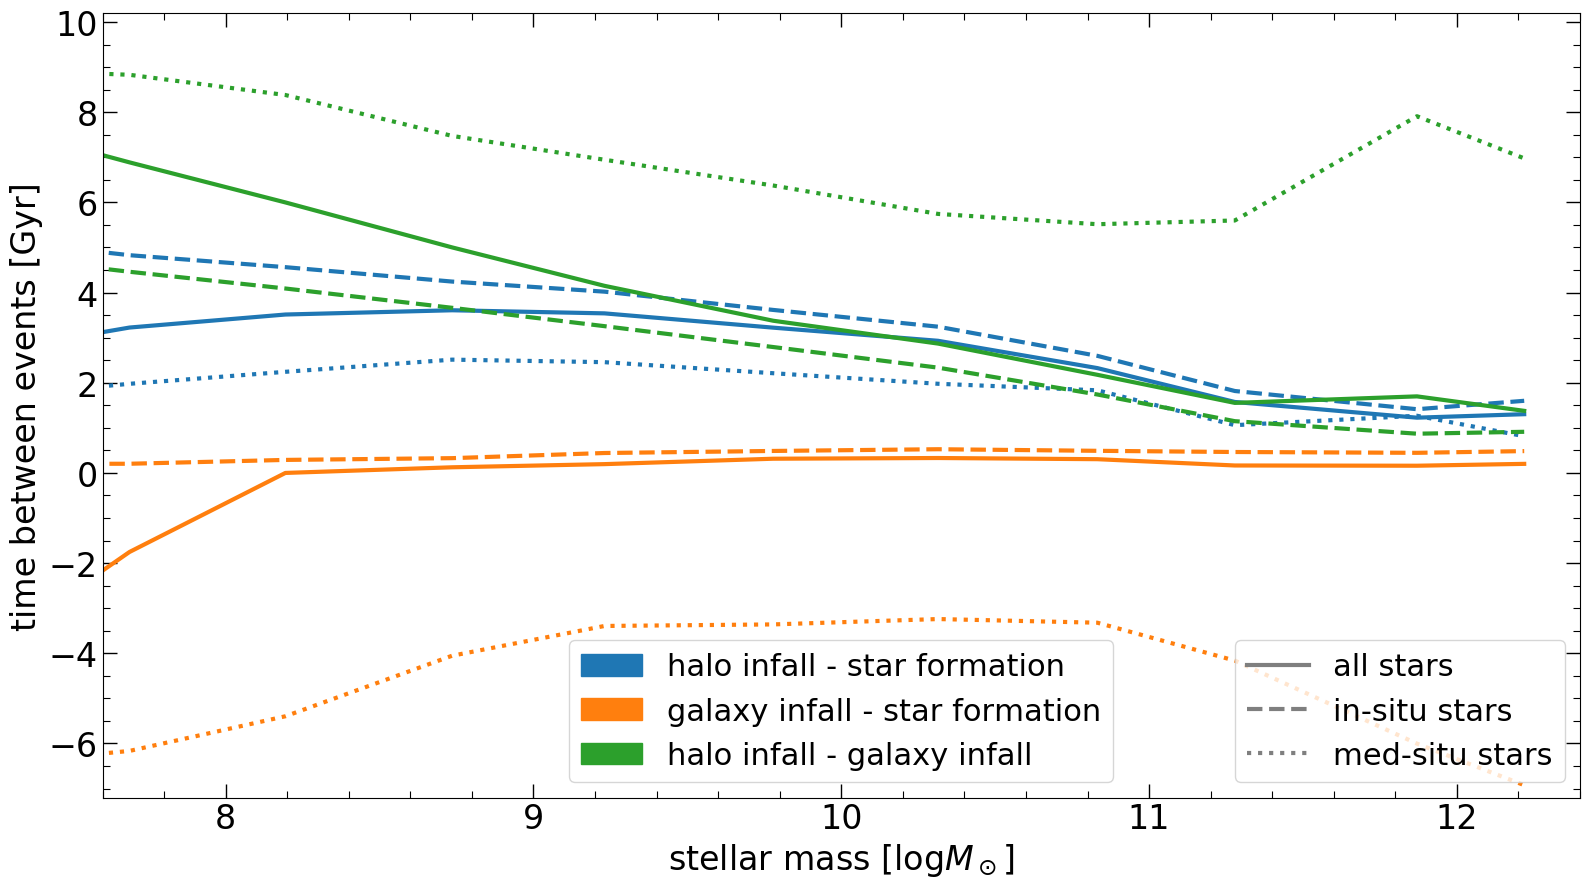

In [24]:
# plt.hist2d(stellar_masses, false_insitu_subs, cmap = 'Blues', norm = mpl.colors.LogNorm(), bins = (128,64))
# plt.colorbar()


plt.plot(mass_bins, halo_star_form_diff_bins_all, color = 'tab:blue', linestyle = 'solid')
plt.plot(mass_bins, halo_star_form_diff_bins_in, color = 'tab:blue', linestyle = 'dashed')
plt.plot(mass_bins, halo_star_form_diff_bins_med, color = 'tab:blue', linestyle = 'dotted')
# plt.plot(mass_bins, halo_star_form_diff_bins_out, color = 'tab:blue', linestyle = 'dashdot')

plt.plot(mass_bins, gal_star_form_diff_bins_all, color = 'tab:orange', linestyle = 'solid')
plt.plot(mass_bins, gal_star_form_diff_bins_in, color = 'tab:orange', linestyle = 'dashed')
plt.plot(mass_bins, gal_star_form_diff_bins_med, color = 'tab:orange', linestyle = 'dotted')

plt.plot(mass_bins, halo_gal_diff_bins_all, color = 'tab:green', linestyle = 'solid')
plt.plot(mass_bins, halo_gal_diff_bins_in, color = 'tab:green', linestyle = 'dashed')
plt.plot(mass_bins, halo_gal_diff_bins_med, color = 'tab:green', linestyle = 'dotted')
# plt.plot(mass_bins, form_out_loc_in_bins, color = 'tab:blue', linestyle = 'dashed')
# plt.plot(mass_bins, form_in_loc_out_bins, color = 'tab:orange', linestyle = 'solid')
# plt.plot(mass_bins, form_out_loc_out_bins, color = 'tab:orange', linestyle = 'dashed')
# plt.plot(mass_bins, med_situ_bins, color = 'tab:green')
# plt.plot(mass_bins, np.nansum(np.array([form_in_loc_in_bins, form_in_loc_out_bins, form_out_loc_in_bins,\
#                                         form_out_loc_out_bins, always_out_bins]), axis = 0), color = 'black')

plt.xlabel(r'stellar mass [$\log{M_\odot}$]')
plt.ylabel('time between events [Gyr]')

z0_loc = mlines.Line2D([], [], color='white', label='at z=0')
blank = mlines.Line2D([], [], color='white')
# halo_star_form = mlines.Line2D([], [], color='tab:blue', linestyle = 'solid', label = 'halo infall - star formation')
# gal_star_form = mlines.Line2D([], [], color='tab:orange', linestyle = 'solid', label = 'galaxy infall - star formation')
# halo_gal = mlines.Line2D([], [], color='tab:green', linestyle = 'solid', label = 'halo infall - galaxy infall')

halo_star_form = mpatches.Patch(color='tab:blue', label = 'halo infall - star formation')
gal_star_form = mpatches.Patch(color='tab:orange', label = 'galaxy infall - star formation')
halo_gal = mpatches.Patch(color='tab:green', label = 'halo infall - galaxy infall')

all_stars = mlines.Line2D([], [], color='tab:gray', linestyle = 'solid', label = 'all stars')
in_stars = mlines.Line2D([], [], color='tab:gray', linestyle = 'dashed', label = 'in-situ stars')
med_stars = mlines.Line2D([], [], color='tab:gray', linestyle = 'dotted', label = 'med-situ stars')
# out_stars = mlines.Line2D([], [], color='tab:gray', linestyle = 'dashdot', label = 'outside stars')


legend1 = plt.legend(handles = [halo_star_form, gal_star_form, halo_gal])
legend2 = plt.legend(handles = [all_stars, in_stars, med_stars], loc= 'lower right')
plt.gca().add_artist(legend1)

plt.xlim(7.6,12.4)
# plt.yscale('symlog')
plt.ylim(-7.2,10.2)
plt.tight_layout()
plt.savefig(f'pics/med-situ/specific_time_diffs_50-{run}.pdf', format = 'pdf')

## histogram of distances at star formation

In [18]:
run = 1
basePath=f'/virgotng/universe/IllustrisTNG/TNG50-{run}/output'
stype = 'insitu'
file = '/vera/ptmp/gc/olwitt/' + stype + f'/TNG50-{run}/infall_and_leaving_times.hdf5'
f = h5py.File(file,'r')
# halo_infall_snaps = f['halo_infall'][:]
galaxy_infall_snaps = f['galaxy_infall'][:]
# IGM_leaving = f['leaving_igm'][:]
f.close()

f = h5py.File('/vera/ptmp/gc/olwitt/' + stype + f'/TNG50-{run}/star_formation_snapshots.hdf5','r')
star_formation_snaps = f['star_formation_snapshot'][:]
f.close()

f = h5py.File('/vera/ptmp/gc/olwitt/' + stype + f'/TNG50-{run}/star_formation_distances.hdf5','r')
star_formation_distances = f['star_formation_distances'][:]
f.close()

f = h5py.File('/vera/ptmp/gc/olwitt/' + stype + f'/TNG50-{run}/parent_indices_99.hdf5','r')
numTracersInParents = f['snap_99/numTracersInParents'][:]
f.close()
insituStarsInSubOffset = tF.insituStarsInSubOffset(basePath,99)
final_offsets = tF.tracersInSubhalo(insituStarsInSubOffset,numTracersInParents).astype(int)
final_offsets = np.insert(final_offsets,0,0)

In [19]:
print(np.where(star_formation_distances > 1000)[0].shape)
print(star_formation_distances.shape)
print(np.where(star_formation_distances == -1)[0].shape)

(6425332,)
(591404257,)
(198295913,)


In [20]:
#compute median distances for ALL galaxies. however, only a small amount of centrals was really used
#-> retrieve that information
@njit
def sub_star_form_distances(offsets, star_formation_snaps, star_formation_distances, galaxy_infall_snaps):
    num_subs = offsets.shape[0] - 1
    
    # 3 bins each for stars formed at z < 0.5, 0.5 < z < 1.5, 1.5 < z (i.e. snaps 67 and 40)
#     mean_sub_star_form_snap = np.full((num_subs,3), np.nan, dtype = np.float32)
    sub_star_form_dist_in = np.full((num_subs,3), np.nan, dtype = np.float32)
    sub_star_form_dist_med = np.full((num_subs,3), np.nan, dtype = np.float32)
    
    for i in range(num_subs):
        indices_of_sub = np.arange(offsets[i],offsets[i+1])
        if indices_of_sub.shape[0] > 0:
            med_situ = np.where(np.logical_or(star_formation_snaps[indices_of_sub] < galaxy_infall_snaps[indices_of_sub],\
                                              galaxy_infall_snaps[indices_of_sub] == -1))[0]
            in_situ = np.where(np.logical_and(star_formation_snaps[indices_of_sub] >= galaxy_infall_snaps[indices_of_sub],\
                                              galaxy_infall_snaps[indices_of_sub] != -1))[0]
            mask = np.full(indices_of_sub.shape[0], -1, dtype = np.byte)
            mask[in_situ] = 0
            mask[med_situ] = 1
            
            if i==110:
                print(np.where(mask == -1)[0].shape[0])
            
            young = np.where(star_formation_snaps[indices_of_sub] >= 67)[0]
            middle = np.where(np.logical_and(star_formation_snaps[indices_of_sub] < 67,\
                                             star_formation_snaps[indices_of_sub] >= 40))[0]
            old = np.where(star_formation_snaps[indices_of_sub] < 40)[0]
            if young.shape[0] > 0:
                young_med = np.where(mask[young] == 1)[0]
                sub_star_form_dist_med[i,0] = np.nanmedian(star_formation_distances[indices_of_sub[young_med]])
                young_in = np.where(mask[young] == 0)[0]
                sub_star_form_dist_in[i,0] = np.nanmedian(star_formation_distances[indices_of_sub[young_in]])
            if middle.shape[0] > 0:
                middle_med = np.where(mask[middle] == 1)[0]
                sub_star_form_dist_med[i,1] = np.nanmedian(star_formation_distances[indices_of_sub[middle_med]])
                middle_in = np.where(mask[middle] == 0)[0]
                sub_star_form_dist_in[i,1] = np.nanmedian(star_formation_distances[indices_of_sub[middle_in]])
            if old.shape[0] > 0:
                old_med = np.where(mask[old] == 1)[0]
                sub_star_form_dist_med[i,2] = np.nanmedian(star_formation_distances[indices_of_sub[old_med]])
                old_in = np.where(mask[old] == 0)[0]
                sub_star_form_dist_in[i,2] = np.nanmedian(star_formation_distances[indices_of_sub[old_in]])
            
            
    return sub_star_form_dist_in, sub_star_form_dist_med

In [21]:
sub_star_form_dist_in, sub_star_form_dist_med =\
sub_star_form_distances(final_offsets, star_formation_snaps, star_formation_distances, galaxy_infall_snaps)

0


In [22]:
file = '/vera/ptmp/gc/olwitt/' + stype + f'/TNG50-{run}/lagrangian_regions/lagrangian_regions_99.hdf5'
f = h5py.File(file,'r')
subhaloFlag_99 = f['subhaloFlag'][:]
# dwarf_inds = f['mass_bin_indices/sub_ids_dwarf'][:]
# mw_inds = f['mass_bin_indices/sub_ids_mw'][:]
# group_inds = f['mass_bin_indices/sub_ids_group'][:]
# giant_inds = f['mass_bin_indices/sub_ids_giant'][:]
f.close()

subs = np.nonzero(subhaloFlag_99)[0] #which subs were used for analysis (at snapshot 99)

In [23]:
h_const = il.groupcat.loadHeader(basePath, 99)['HubbleParam']
stellar_masses = il.groupcat.loadSubhalos(basePath, 99, fields = ['SubhaloMassType'])[:,4] * 1e10 / h_const
stellar_masses = funcs.log10_mod(stellar_masses[subs])
sub_star_form_dist_in = sub_star_form_dist_in[subs,:]
sub_star_form_dist_med = sub_star_form_dist_med[subs,:]

In [24]:
num_bins = 15
mass_bins, bins_young, _, _ = funcs.binData_med(stellar_masses, sub_star_form_dist_in[:,0], num_bins)
_, bins_middle, _, _ = funcs.binData_med(stellar_masses, sub_star_form_dist_in[:,1], num_bins)
_, bins_old, _, _ = funcs.binData_med(stellar_masses, sub_star_form_dist_in[:,2], num_bins)

_, bins_young_med, _, _ = funcs.binData_med(stellar_masses, sub_star_form_dist_med[:,0], num_bins)
_, bins_middle_med, _, _ = funcs.binData_med(stellar_masses, sub_star_form_dist_med[:,1], num_bins)
_, bins_old_med, _, _ = funcs.binData_med(stellar_masses, sub_star_form_dist_med[:,2], num_bins)

/mpcdf/soft/SLE_15/packages/x86_64/anaconda/3/2020.02/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1116: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)
/mpcdf/soft/SLE_15/packages/x86_64/anaconda/3/2020.02/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1372: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input, interpolation=interpolation


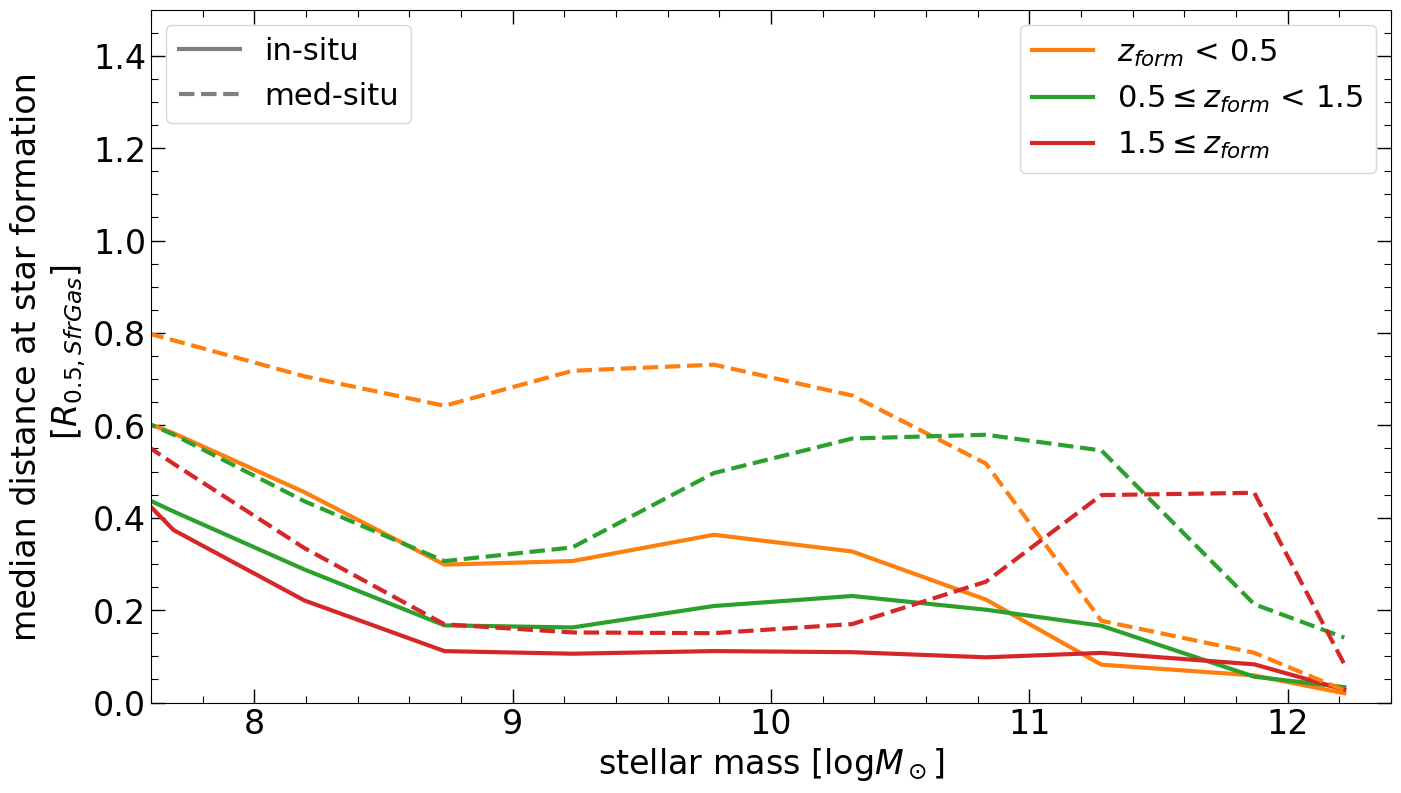

In [25]:
# plot_dist = np.nanmedian(mean_sub_star_form_dist,axis = 1)
# mask = np.asarray(plot_dist < 1)
# res = np.zeros(plot_dist.shape[0]) + 1
# res[mask] = plot_dist[mask]
# plt.hist2d(stellar_masses, res, cmap = 'Blues', norm = mpl.colors.LogNorm(), bins = (128,64),)
# plt.colorbar()

l1 = plt.plot(mass_bins, bins_young, color = 'tab:orange', label = '$z_{form}$ < 0.5')
l2 = plt.plot(mass_bins, bins_middle, color = 'tab:green', label = '$0.5 \leq z_{form}$ < 1.5')
l3 = plt.plot(mass_bins, bins_old, color = 'tab:red', label = '$1.5 \leq z_{form}$')

l4 = plt.plot(mass_bins, bins_young_med, color = 'tab:orange', linestyle = 'dashed')
l5 = plt.plot(mass_bins, bins_middle_med, color = 'tab:green', linestyle = 'dashed')
l6 = plt.plot(mass_bins, bins_old_med, color = 'tab:red', linestyle = 'dashed')

plt.xlabel(r'stellar mass [$\log{M_\odot}$]')
plt.ylabel('median distance at star formation\n'+r' [$R_{0.5,SfrGas}$]')

legend1 = plt.legend()

form_in = mlines.Line2D([], [], color='tab:gray', linestyle = 'solid', label='in-situ')
form_out = mlines.Line2D([], [], color='tab:gray', linestyle = 'dashed', label='med-situ')

legend2 = plt.legend(handles = [form_in, form_out], loc = 'upper left')
plt.gca().add_artist(legend1)

plt.ylim(0,1.5)
plt.xlim(7.6,12.4)
# plt.yscale('log')


plt.savefig(f'pics/med-situ/dist_at_star_formation_50-{run}.pdf', format = 'pdf')

choose single galaxy (i.e. central of MW halo) and plot histogram (not mass trend) of distance at star formation

In [12]:
which = 0
sub_id = tF.getIndices(giant_inds,subs)[which]
print(sub_id)

0


In [13]:
#compute median distances for ALL galaxies. however, only a small amount of centrals was really used
#-> retrieve that information
def individual_sub_star_form_distances(offsets, star_formation_snaps, star_formation_distances, sub_id):
    
    indices_of_sub = np.arange(offsets[sub_id],offsets[sub_id + 1])
    dist_at_star_form = {}
    
    if indices_of_sub.shape[0] > 0:
        young = np.where(star_formation_snaps[indices_of_sub] >= 67)[0]
        middle = np.where(np.logical_and(star_formation_snaps[indices_of_sub] < 67,\
                                         star_formation_snaps[indices_of_sub] >= 40))[0]
        old = np.where(star_formation_snaps[indices_of_sub] < 40)[0]
        if young.shape[0] > 0:
            dist_at_star_form['young'] = star_formation_distances[indices_of_sub[young]]
        if middle.shape[0] > 0:
            dist_at_star_form['middle'] = star_formation_distances[indices_of_sub[middle]]
        if old.shape[0] > 0:
            dist_at_star_form['old'] = star_formation_distances[indices_of_sub[old]]
        dist_at_star_form['all'] = star_formation_distances[indices_of_sub]
            
            
    return dist_at_star_form

In [14]:
dist_at_star_form = individual_sub_star_form_distances(final_offsets, star_formation_snaps, star_formation_distances,\
                                                       sub_id)

In [40]:
# plt.hist(dist_at_star_form['old'], range = (0,10))
bins, nums = funcs.binData(dist_at_star_form['all'], 15, mode = 'num', fixed_bins = True, mini = 0, maxi = 10 )
bins, nums1 = funcs.binData(dist_at_star_form['young'], 15, mode = 'num', fixed_bins = True, mini = 0, maxi = 10 )
bins, nums2 = funcs.binData(dist_at_star_form['middle'], 15, mode = 'num', fixed_bins = True, mini = 0, maxi = 10 )
bins, nums3 = funcs.binData(dist_at_star_form['old'], 15, mode = 'num', fixed_bins = True, mini = 0, maxi = 10 )

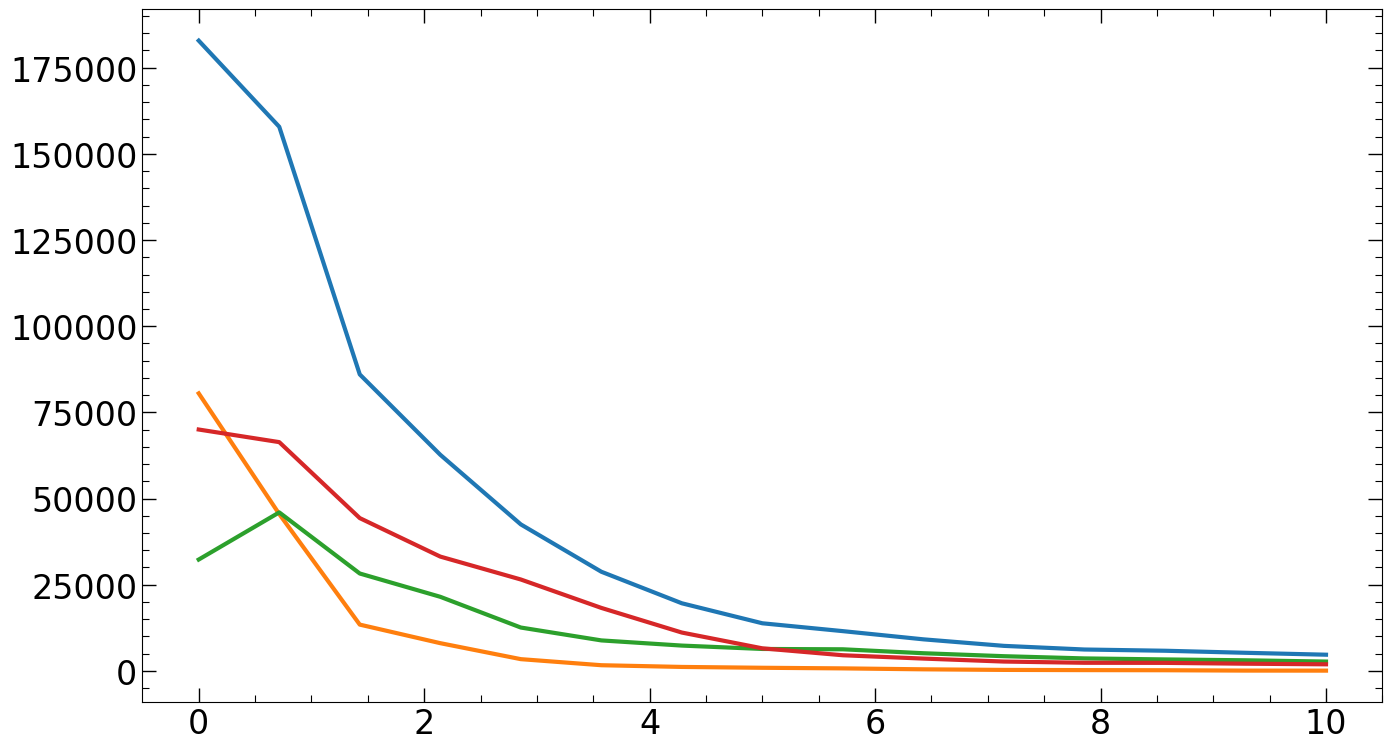

In [41]:
plt.plot(bins,nums)
plt.plot(bins,nums1)
plt.plot(bins,nums2)
plt.plot(bins,nums3)